In [1]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd #data processing

import os
import re
import nltk

In [2]:
train=pd.read_csv('E:\\Kaggle\\Disaster Tweets\\train.csv')
test=pd.read_csv('E:\\Kaggle\\Disaster Tweets\\test.csv')

In [3]:
print(train.shape, test.shape)

(7613, 3) (3263, 2)


In [4]:
print(train.isnull().sum())
print('************')
print(test.isnull().sum())

id        0
text      0
target    0
dtype: int64
************
id      0
text    0
dtype: int64


In [5]:
test=test.fillna(' ')
train=train.fillna(' ')

In [6]:
real_words = ''
fake_words = ''
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train[train['target']==1].text: 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    real_words += " ".join(tokens)+" "

for val in train[train['target']==0].text: 
      
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    fake_words += " ".join(tokens)+" "

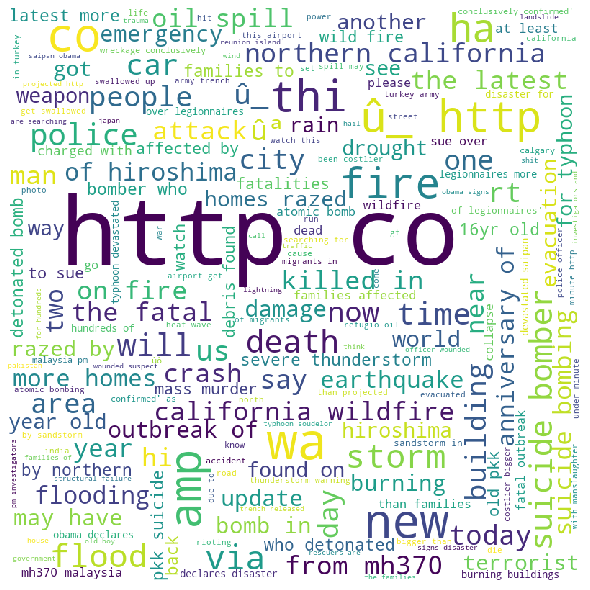

In [7]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(real_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

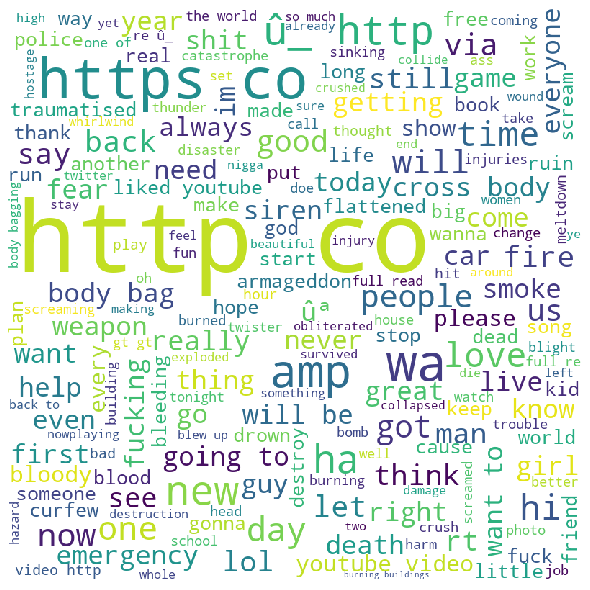

In [8]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(fake_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:
#Cleaning and preprocessing
stop_words = stopwords.words('english')
lemmatizer=WordNetLemmatizer()
for index,row in train.iterrows():
    filter_sentence = ''
    
    sentence = row['text']
    sentence = re.sub(r'[^\w\s]','',sentence) #cleaning
    
    words = nltk.word_tokenize(sentence) #tokenization
    
    words = [w for w in words if not w in stop_words]  #stopwords removal
    
    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
        
    train.loc[index,'text'] = filter_sentence

In [11]:
train = train[['text','target']]

In [12]:
#NLP Techniques
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
X_train = train['text']
Y_train = train['target']

In [18]:
#Feature extraction using count vectorization and tfidf.
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)
freq_term_matrix = count_vectorizer.transform(X_train)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [19]:
tf_idf_matrix

<7613x22070 sparse matrix of type '<class 'numpy.float64'>'
	with 78147 stored elements in Compressed Sparse Row format>

In [20]:
test_counts = count_vectorizer.transform(test['text'].values)
test_tfidf = tfidf.transform(test_counts)

#split in samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state=0)

In [21]:
#Multinomial Bayes
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
pred = NB.predict(X_test)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))
cm = confusion_matrix(y_test, pred)
cm

Accuracy of NB  classifier on training set: 0.91
Accuracy of NB classifier on test set: 0.80


array([[1019,   88],
       [ 295,  502]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report, accuracy_score

In [23]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1107
           1       0.85      0.63      0.72       797

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.78      1904
weighted avg       0.81      0.80      0.79      1904



In [24]:
test_vect =tfidf.transform(test_tfidf).toarray()

In [25]:
test_vect.shape

(3263, 22070)

In [26]:
final_predictions = NB.predict(test_vect)

In [27]:
final_predictions

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [28]:
submission_df = pd.DataFrame()

In [29]:
y_test.head()

311     0
4970    0
527     0
6362    0
800     0
Name: target, dtype: int64

In [31]:
Submission = pd.DataFrame({"id" : test["id"], "target":final_predictions})

In [32]:
Submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [33]:
Submission['target'].value_counts()

0    2304
1     959
Name: target, dtype: int64

In [34]:
sub = Submission.to_csv('Result.csv',index = False)